### Imports and Definitions

In [282]:
from functions import *
from SQL_functions import *
from stats_forumulas import *
import config
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from mysql.connector import errorcode
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Do abortion laws influence how many women end up working in tech?

We have two measures of "women working in tech":
 - Prevalence of women in tech (percentage of tech industry workers who are women)
 - Percentage difference of prevalence of women in tech versus prevalence of women in workforce overall
 
Let's try each of these and see the result.

#### Influence of Abortion: Using Prevalence of Women in Tech

**Hypothesis:** if we group countries by their abortion laws, we should find the one of these groups has a statistically significant difference in the prevalence of women in tech.

In [168]:
# Let's grab relevant data from the AWS MySQL database,
# and put it into a pandas DataFrame for analysis.

query1 = get_attributes_query(('value', 'laws'), 'abortion_info',
                              ('percent_women_in_tech', 'prevalence_of_women_in_tech'))
df1 = get_data(query1)

In [169]:
# Let's take a peek at our data

df1.sample(5)

,country,laws,prevalence_of_women_in_tech
38,Turkey,7,9.91
24,Luxembourg,6,13.89
33,Slovakia,7,9.29
16,Iceland,6,22.08
1,Austria,7,17.19


Now let's run an ANOVA test with $\alpha = 0.05$

We are grouping by the country's abortion laws (1 = strict, 7 = lenient). 

These are reflected in categories, as defined by UN Data. 

We are trying to see if there is a significant difference in
prevalence of women in tech among these groups.

In [183]:
anova_table_and_summary(df1, 'prevalence_of_women_in_tech', 'laws')


,sum_sq,df,F,PR(>F)
C(laws),68.655040,4.0,0.62966,0.644498
Residual,981.316408,36.0,NaN,NaN


We find an F-statistic of 0.6297, corresponding to a p-value of 0.644, which is not enough to reject the null hypothesis with $\alpha = 0.05$

Using the table summary and an external F-table, we also manually confirmed these scores:

    F = (68.655040/4)/(981.316408/36) = 0.6296...

    p = 1-.356 = 0.644

Let's try to get an idea of what the distribution of each group looks like with a box plot:

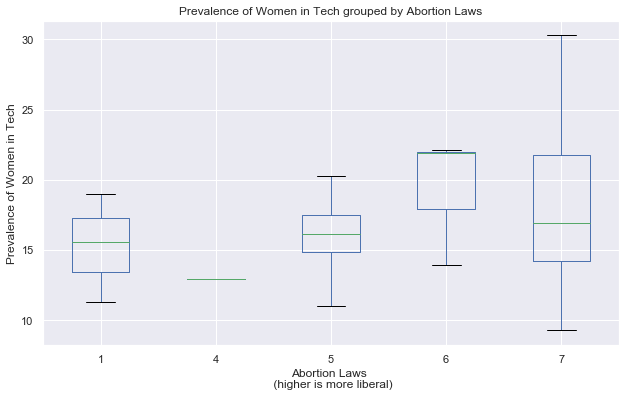

In [308]:
fig, ax = plt.subplots(figsize=(10,6))
df1.boxplot('prevalence_of_women_in_tech', by='laws', ax=ax);
ax.set_xlabel('Abortion Laws \n (higher is more liberal)')
ax.set_ylabel('Prevalence of Women in Tech')
ax.set_title('Prevalence of Women in Tech grouped by Abortion Laws')
fig.suptitle("");

We can also look at summary statistics.

In [186]:
df1.groupby('laws').describe()

prevalence_of_women_in_tech                                               \
                           count       mean       std    min      25%     50%   
laws                                                                            
1                            3.0  15.250000  3.847649  11.27  13.4000  15.530   
4                            1.0  12.910000       NaN  12.91  12.9100  12.910   
5                            6.0  15.981667  3.132905  11.00  14.8775  16.105   
6                            3.0  19.300000  4.685798  13.89  17.9100  21.930   
7                           28.0  18.062500  5.639539   9.29  14.1800  16.885   

                      
          75%    max  
laws                  
1     17.2400  18.95  
4     12.9100  12.91  
5     17.4975  20.25  
6     22.0050  22.08  
7     21.7675  30.28

 Notice that we have very few countries who are not in category 7 (most lenient). This may be hurting our chances of finding a statistically significant result. That being said, the means among groups do not seem to differ greatly.

#### Influence of Abortion on the "Tech Prevalence Gap" for Women:
Measuring the Difference Between the Prevalence of Women in Tech and 

the Prevalence of Women in the Overall Workforce 

(both measured as percentages)

**Hypothesis:** If we group countries by their abortion laws, we should find that one of these groups has a statistically significant difference in their tech prevalence gap for women.

In [188]:
# Let's grab relevant data from the AWS MySQL database,
# and put it into a pandas DataFrame for analysis.

query2 = get_attributes_query(('value', 'laws'), 'abortion_info',
                              ('percent_difference_of_women_in_workforce_and_women_in_tech', 'tech_prevalence_gap'))

df2 = get_data(query2)

In [189]:
# Let's take a peek at our data
df2.sample(5)

,country,laws,tech_prevalence_gap
1,Austria,7,-29.63
3,Bulgaria,7,-16.63
15,Hungary,7,-32.61
10,Estonia,7,-29.77
19,Italy,7,-28.16


Now let's run an ANOVA test with $\alpha = 0.05$

We are grouping by abortion laws (1 = strict, 7 = lenient), and trying to see if there is a significant difference in the tech prevalence gap for women.

In [191]:
anova_table_and_summary(df2, 'tech_prevalence_gap', 'laws')

,sum_sq,df,F,PR(>F)
C(laws),44.331711,4.0,0.496033,0.738689
Residual,804.352211,36.0,NaN,NaN


We find an F-statistic of 0.496, corresponding to a p-value of 0.73, which is not enough to reject the null hypothesis with $\alpha = 0.05$

Let's try to get an idea of what the distribution of each group looks like with a box plot:

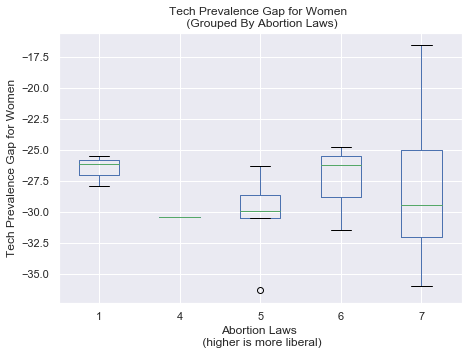

In [283]:
fig, ax = plt.subplots(figsize=(7,5))
df2.boxplot('tech_prevalence_gap', by='laws', ax=ax);
ax.set_xlabel('Abortion Laws \n (higher is more liberal)')
ax.set_ylabel('Tech Prevalence Gap for Women')
ax.set_title('Tech Prevalence Gap for Women \n (Grouped By Abortion Laws)')
fig.suptitle("");

Again, there is no clear pattern here.

## Let's redo those same tests, but this time with fewer categories (just to see what happens)

We might think that perhaps the fact that many categories only have a handful of data points may have hurt the ability of our ANOVA to reach statistical significance. 

Let's examine both of these findings, but now grouping the laws into two categories that are split by the mode of observations, and ordered by their lenience.

### Prevalence of Women in Tech

In [226]:
# Create new data frame with re-categorized data for the abortion laws

df1_recat = df1.copy(deep=True)
df1_recat['laws'] = df1_recat['laws'].apply(lambda x: 1 if x > 6 else 0)

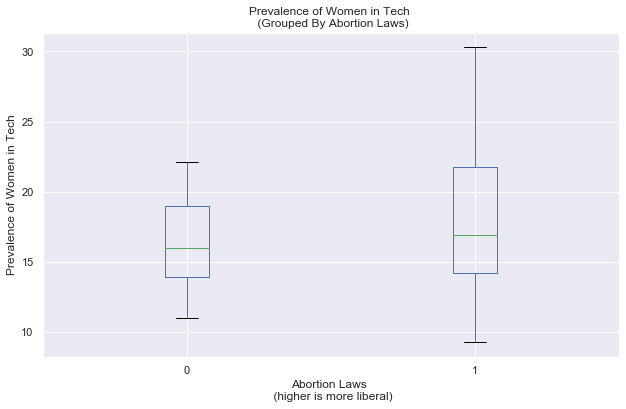

In [284]:
# View boxplot of findings

fig, ax = plt.subplots(figsize=(10,6))
df1_recat.boxplot('prevalence_of_women_in_tech', by='laws', ax=ax);
ax.set_xlabel('Abortion Laws \n (higher is more liberal)')
ax.set_ylabel('Prevalence of Women in Tech')
ax.set_title('Prevalence of Women in Tech \n (Grouped By Abortion Laws)')
fig.suptitle("");

In [231]:
# Now let's run the ANOVA test to make sure our findings are consistent

anova_table_and_summary(df1_recat, 'prevalence_of_women_in_tech', 'laws')

,sum_sq,df,F,PR(>F)
C(laws),26.270693,1.0,1.000836,0.323275
Residual,1023.700756,39.0,NaN,NaN


Here we find an F-statistic of 1.001, corresponding to a p-value of 0.32, which is not enough to reject the null hypothesis with $\alpha = 0.05$, again failing to reject the null for prevalence of women in tech.

### Tech Prevalence Gap for Women

In [228]:
# Create new data frame with re-categorized data for the abortion laws

df2_recat = df2.copy(deep=True)
df2_recat['laws'] = df2_recat['laws'].apply(lambda x: 1 if x > 6 else 0)

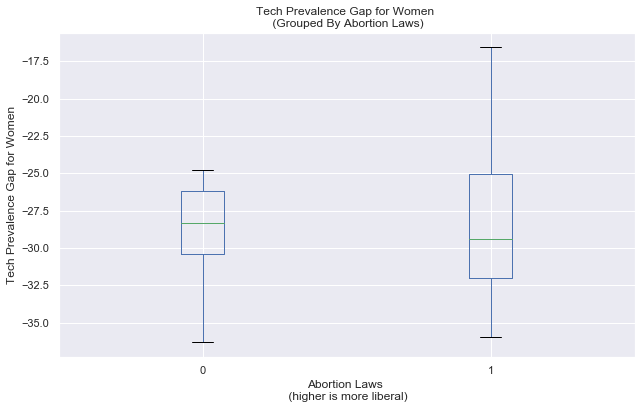

In [229]:
# Let's look at the boxplot

fig, ax = plt.subplots(figsize=(10,6))
df2_recat.boxplot('tech_prevalence_gap', by='laws', ax=ax);
ax.set_xlabel('Abortion Laws \n (higher is more liberal)')
ax.set_ylabel('Tech Prevalence Gap for Women')
ax.set_title('Tech Prevalence Gap for Women \n (Grouped By Abortion Laws)')
fig.suptitle("");

In [230]:
# Now let's run the ANOVA test to make sure our findings are consistent

anova_table_and_summary(df2_recat, 'tech_prevalence_gap', 'laws')

,sum_sq,df,F,PR(>F)
C(laws),8.853188,1.0,0.411124,0.52515
Residual,839.830734,39.0,NaN,NaN


Here we find an F-statistic of 0.411, corresponding to a p-value of 0.52, which is not enough to reject the null hypothesis with $\alpha = 0.05$, again failing to reject the null for tech prevalence gap for women.

**Still no significant differences!**

## Attempting to replicate a study (with restricted countries):
Study found here: https://www.theatlantic.com/science/archive/2018/02/the-more-gender-equality-the-fewer-women-in-stem/553592/ 

**Does a higher gender inequality index *increase* the percentage of STEM graduates who are female, as this counter-intuitive study suggests?**

We will try to replicate the study using Honeypot data, and restricting to only countries in the EU or OECD

In [233]:
# First let's grab our gender inequality data.

inequality_query = \
    get_attributes_query(('gender_inequality_index', 'gender_inequality_index'), 'women_in_tech',
                         ('female_stem_graduates_percentage','female_stem_graduates_percentage'))

gend_df = get_data(inequality_query)

In [310]:
# Take a peak at the data

gend_df.sample(15)

,country,gender_inequality_index,female_stem_graduates_percentage,gender_inequality_index_cat
30,Poland,0.137,25.93,True
8,Czech Republic,0.129,23.08,True
9,Denmark,0.041,28.57,False
34,Slovenia,0.053,21.88,False
10,Estonia,0.131,21.26,True
2,Belgium,0.073,18.03,False
20,Japan,0.116,15.25,False
27,Netherlands,0.044,18.70,False
7,Cyprus,0.116,28.57,False
40,United States of America,0.203,24.24,True


We want to take a look at the distribution of the continuous variable "gender_inequality_index" (our independent variable) to see what the most sensible way of turning it into categorical data is:

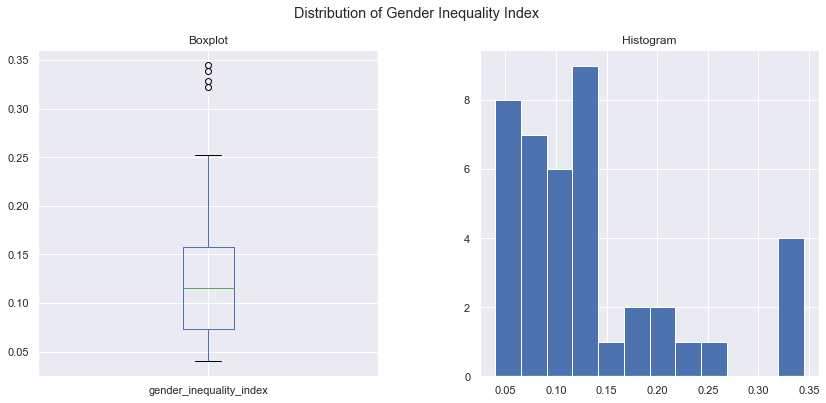

In [267]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
fig.suptitle('Distribution of Gender Inequality Index')
gend_df.boxplot('gender_inequality_index', ax = ax1)
ax1.set_title('Boxplot');
gend_df.hist('gender_inequality_index', bins = 12, ax = ax2);
ax2.set_title('Histogram');

This is not unimodal, so perhaps our best bet is to divide it into two equal groups, by those above versus below the median value.

In [270]:
# Create a new Boolean column for whether the gender inequality index is above the median or not.

med = gend_df['gender_inequality_index'].median()

gend_df['gender_inequality_index_cat'] = \
    gend_df['gender_inequality_index'].apply(lambda x: True if x > med else False)

print("Median =", med)

Median = 0.116


In [271]:
# Take a peak at our new column

gend_df.head(3)

,country,gender_inequality_index,female_stem_graduates_percentage,gender_inequality_index_cat
0,Australia,0.120,23.66,True
1,Austria,0.078,20.63,False
2,Belgium,0.073,18.03,False


We're now going to run a two-sample t-test with $\alpha = 0.05$. 

We are running a one-tailed test, because we expect that the group with above-median gender inequality index will have a higher percentage of female STEM graduates (as the above study suggests). 

Our null hypothesis is that the group with above-median gender inquality index will have a lower-or-equal percentage of female STEM graduates.

In [273]:
# Calculate the difference in means

mean_above_median = gend_df[gend_df['gender_inequality_index_cat'] == True]['female_stem_graduates_percentage'].mean()
mean_below_median = gend_df[gend_df['gender_inequality_index_cat'] == False]['female_stem_graduates_percentage'].mean()

print('Difference in means :' , mean_above_median - mean_below_median)

Difference in means : 1.0820714285714281


There is a difference of 1.08 in means between the two groups, with the higher-inequality group having higher mean female STEM graduates! But is this difference statistically significant enough to reject the null hypothesis? 

Let's check by running the t-test!

In [25]:
stats.ttest_ind(gend_df[gend_df['gender_inequality_index_cat'] == False]['female_stem_graduates_percentage'],
                gend_df[gend_df['gender_inequality_index_cat'] == True]['female_stem_graduates_percentage'])

Ttest_indResult(statistic=-0.6783800154046294, pvalue=0.5015364299038596)

Here we can see that $p=0.502$, which is not less than $\alpha = 0.05$, so this t-test fails: we cannot reject the null hypthesis, and have failed to replicate the study. 

This raises the question: **why**?

Let's try to find the correlation coefficient between the percentage of STEM graduates who are female and the gender inequality index as continuous variables (without categorization). We hope to see if, perhaps, the effect only appeared for the original researchers because they were capturing information that our naive categorization of a continuous variable smudged over:

In [274]:
corr_co, prob_corr = stats.pearsonr(gend_df['gender_inequality_index'], gend_df['female_stem_graduates_percentage'])
print('Correlation Coefficient:', corr_co)
print('Two-tailed p-value:', prob_corr)

Correlation Coefficient: 0.2019175212513302
Two-tailed p-value: 0.20551051457631953


Even still, we get a p-value of $p=0.502$, so do *not* get significance on a level below $\alpha = 0.05$. So we still don't know why we have not replicated the original study.

Perhaps we can do a scatter plot of our data to compare with the scatter plot of the authors. We should also transform our measure of gender inequality to one similar to the measure of gender *equality* used by the authors. We do this through the transformation $x \mapsto 1-x$

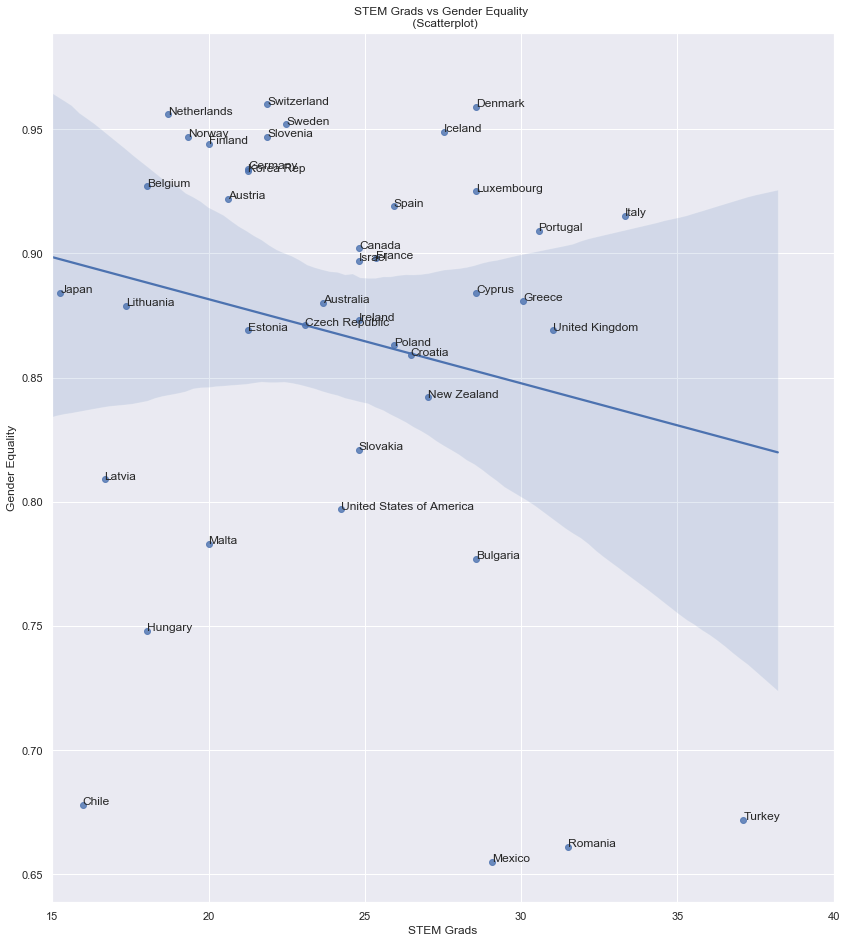

In [307]:
sns.set(rc = {'figure.figsize': (14,16)});
txt = list(gend_df['country']);
x = list(gend_df['female_stem_graduates_percentage']);
y = list(1-(gend_df["gender_inequality_index"]));
ax = sns.regplot(x,y);
ax.set(title = 'STEM Grads vs Gender Equality \n (Scatterplot)', xlabel='STEM Grads', ylabel='Gender Equality', xlim = (15,40));
for i in range(len(txt)):
    ax.annotate(txt[i], (x[i], y[i]));

**Their Scatterplot:**
![](stem_grad_graph.png)

## Third Hypothesis: Female Higher Ed Enrollment versus Proportion of Women Workers in Tech

Our hypothesis is that the enrollment of women in tertiary education (normalized by total population) should be negatively related to the proportion of women workers in tech.
        
That is, when women have more access to higher education, they will choose to enter tech fields less often.

In [287]:
# Getting the data from AWS into a dataframe
higher_ed_query = '''
        SELECT
            w. country
                AS country,
            100*w.female_tech_workforce_thousands / (w.female_workforce_millions * 1000)
                AS perc_women_workers_in_tech,
            100 * max(t.value) / p.value
                AS women_enrolled_in_ter_ed_normalized_by_total_pop
        FROM
            gender.women_in_tech AS w
            JOIN
            gender.ter_ed_enrollment AS t
            ON w.country = t.country
            JOIN gender.population_data_full as p
            ON w.country = p.country
        WHERE
            t.subgroup = "Female"
        GROUP BY
            t.country;'''


df_edu = get_data(higher_ed_query)

df_edu['women_enrolled_in_ter_ed_normalized_by_total_pop'] = \
    df_edu['women_enrolled_in_ter_ed_normalized_by_total_pop'].astype(float)


In [290]:
# Let's see what we're working with

df_edu.describe()

,perc_women_workers_in_tech,women_enrolled_in_ter_ed_normalized_by_total_pop
count,40.000000,40.000000
mean,1.312017,2.157532
std,0.592916,0.847535
min,0.252336,0.269900
25%,0.852204,1.670275
50%,1.337193,2.096250
75%,1.603316,2.663575
max,2.759690,4.286200


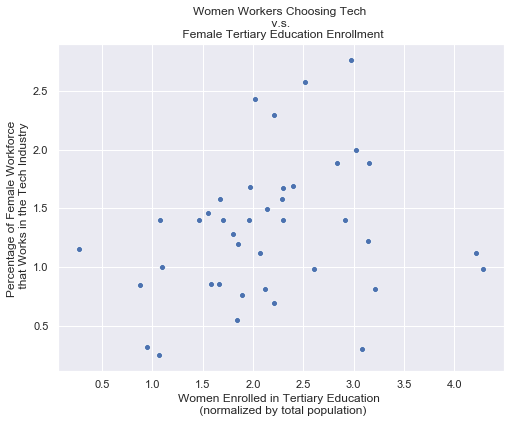

In [295]:
# Let's look at this info in a scatterplot

fig, ax = plt.subplots(figsize=(8,6))
x = df_edu['women_enrolled_in_ter_ed_normalized_by_total_pop']
y = df_edu['perc_women_workers_in_tech']
sns.scatterplot(x,y)
ax.set_xlabel("Women Enrolled in Tertiary Education \n (normalized by total population)")
ax.set_ylabel("Percentage of Female Workforce \n that Works in the Tech Industry")
ax.set_title("Women Workers Choosing Tech \n v.s. \n Female Tertiary Education Enrollment")
plt.show()

Let's do what we did above, and recategorize our data at the median value of higher ed enrollment to run a t-test:

In [302]:
med2 = df_edu['women_enrolled_in_ter_ed_normalized_by_total_pop'].median()
print('Median:', med2)

Median: 2.09625


In [303]:
# True if the higher ed enrollment is above the median, otherwise false

df_edu['women_enrolled_in_ter_ed_normalized_by_total_pop_cat'] = \
    df_edu['women_enrolled_in_ter_ed_normalized_by_total_pop'].apply\
            (lambda x: True if x > med2 else False)

In [306]:
x = df_edu[df_edu['women_enrolled_in_ter_ed_normalized_by_total_pop_cat'] == True]['perc_women_workers_in_tech']
y = df_edu[df_edu['women_enrolled_in_ter_ed_normalized_by_total_pop_cat'] == False]['perc_women_workers_in_tech']
stats.ttest_ind(x,y)

Ttest_indResult(statistic=1.8221744484533022, pvalue=0.07630582090113038)

We have a p value of 0.076, which is not less than $\alpha=0.05$ as is our threshhold for rejecting the null hypothesis. 

We can also run a test without our categorization (just as a curiosity: we could not use this result, due to already having done a t-test on the same data).

In [37]:
stats.pearsonr(df_edu['perc_women_workers_in_tech'], df_edu['women_enrolled_in_ter_ed_normalized_by_total_pop'])

(0.23181881073105137, 0.1500511224010598)

Interestingly, this has an even higher p-value, so we would be even fruther from rejecting the null hypothesis here!

It is more likely than not that the null hypothesis is false, but this was not the standard we have set, so we cannot reject the null.